In [81]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from scipy.stats import zscore


In [82]:
from google.colab import drive
drive.mount('/content/drive')
df = pd.read_csv('/content/drive/My Drive/12dataset.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [83]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72675 entries, 0 to 72674
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Datetime                72675 non-null  object 
 1   Temperature             72675 non-null  float64
 2   Humidity                72675 non-null  float64
 3   WindSpeed               72675 non-null  float64
 4   GeneralDiffuseFlows     72675 non-null  float64
 5   DiffuseFlows            72675 non-null  float64
 6   PowerConsumption_Zone1  72675 non-null  float64
 7   PowerConsumption_Zone2  72675 non-null  float64
 8   PowerConsumption_Zone3  72675 non-null  float64
dtypes: float64(8), object(1)
memory usage: 5.0+ MB


In [84]:
df.head(10)

,Datetime,Temperature,Humidity,WindSpeed,GeneralDiffuseFlows,DiffuseFlows,PowerConsumption_Zone1,PowerConsumption_Zone2,PowerConsumption_Zone3
0,1/1/2017 0:00,6.559000,73.800000,0.083000,0.051000,0.119000,34055.69620,16128.87538,20240.96386
1,1/1/2017 0:10,6.414000,74.500000,0.083000,0.070000,0.085000,29814.68354,19375.07599,20131.08434
2,1/1/2017 0:20,222.819286,613.824254,84.356552,9456.659606,4432.016495,282457.08970,203502.40740,250092.16980
3,1/1/2017 0:30,222.819286,613.824254,84.356552,9456.659606,4432.016495,282457.08970,203502.40740,250092.16980
4,1/1/2017 0:40,5.921000,75.700000,0.081000,0.048000,0.085000,27335.69620,17872.34043,18442.40964
5,1/1/2017 0:50,5.853000,76.900000,0.081000,0.059000,0.108000,26624.81013,17416.41337,18130.12048
6,1/1/2017 1:00,5.641000,77.700000,0.080000,0.048000,0.096000,25998.98734,16993.31307,17945.06024
7,1/1/2017 1:10,5.496000,78.200000,0.085000,0.055000,0.093000,25446.07595,16661.39818,17459.27711
8,1/1/2017 1:20,5.678000,78.100000,0.081000,0.066000,0.141000,24777.72152,16227.35562,17025.54217
9,1/1/2017 1:30,5.491000,77.300000,0.082000,0.062000,0.111000,24279.49367,15939.20973,16794.21687


In [85]:
# Convert Datetime column to datetime format
df['Datetime'] = pd.to_datetime(df['Datetime'], errors='coerce')
print(df['Datetime'].isna().sum())


0


In [86]:
# Example: Adjusting IQR multiplier
def remove_outliers_iqr(dataframe, column, multiplier=1.5):  # Added multiplier parameter
    Q1 = dataframe[column].quantile(0.25)
    Q3 = dataframe[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - multiplier * IQR
    upper_bound = Q3 + multiplier * IQR
    return dataframe[(dataframe[column] >= lower_bound) & (dataframe[column] <= upper_bound)]

# Apply with a different multiplier (e.g., 3)
numeric_columns = df.select_dtypes(include=['float64']).columns
for col in numeric_columns:
    df = remove_outliers_iqr(df, col, multiplier=3)

In [87]:
# Check for duplicate rows
print(f"Total Duplicates: {df.duplicated().sum()}")

# Remove duplicates
df = df.drop_duplicates()


Total Duplicates: 15505


In [88]:
# Check for missing values
print(df.isnull().sum())

# If any missing values exist, fill with mean (or choose other strategies)
df.fillna(df.mean(), inplace=True)


Datetime                  0
Temperature               0
Humidity                  0
WindSpeed                 0
GeneralDiffuseFlows       0
DiffuseFlows              0
PowerConsumption_Zone1    0
PowerConsumption_Zone2    0
PowerConsumption_Zone3    0
dtype: int64


In [89]:
from sklearn.preprocessing import StandardScaler

# Standardizing the numerical columns
scaler = StandardScaler()
df[numeric_columns] = scaler.fit_transform(df[numeric_columns])

print("Data normalization complete!")


Data normalization complete!


In [90]:
#Extract Time Features from the Datetime column (e.g., Hour, Day, Month, Weekday)
df['Hour'] = df['Datetime'].dt.hour
df['Day'] = df['Datetime'].dt.day
df['Month'] = df['Datetime'].dt.month
df['Weekday'] = df['Datetime'].dt.weekday


In [91]:
df['Prev_Hour_Power_Zone1'] = df['PowerConsumption_Zone1'].shift(1)
df['Prev_Hour_Power_Zone2'] = df['PowerConsumption_Zone2'].shift(1)
df['Prev_Hour_Power_Zone3'] = df['PowerConsumption_Zone3'].shift(1)


<ipython-input-92-cab2344229a6>:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45)
<ipython-input-92-cab2344229a6>:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45)


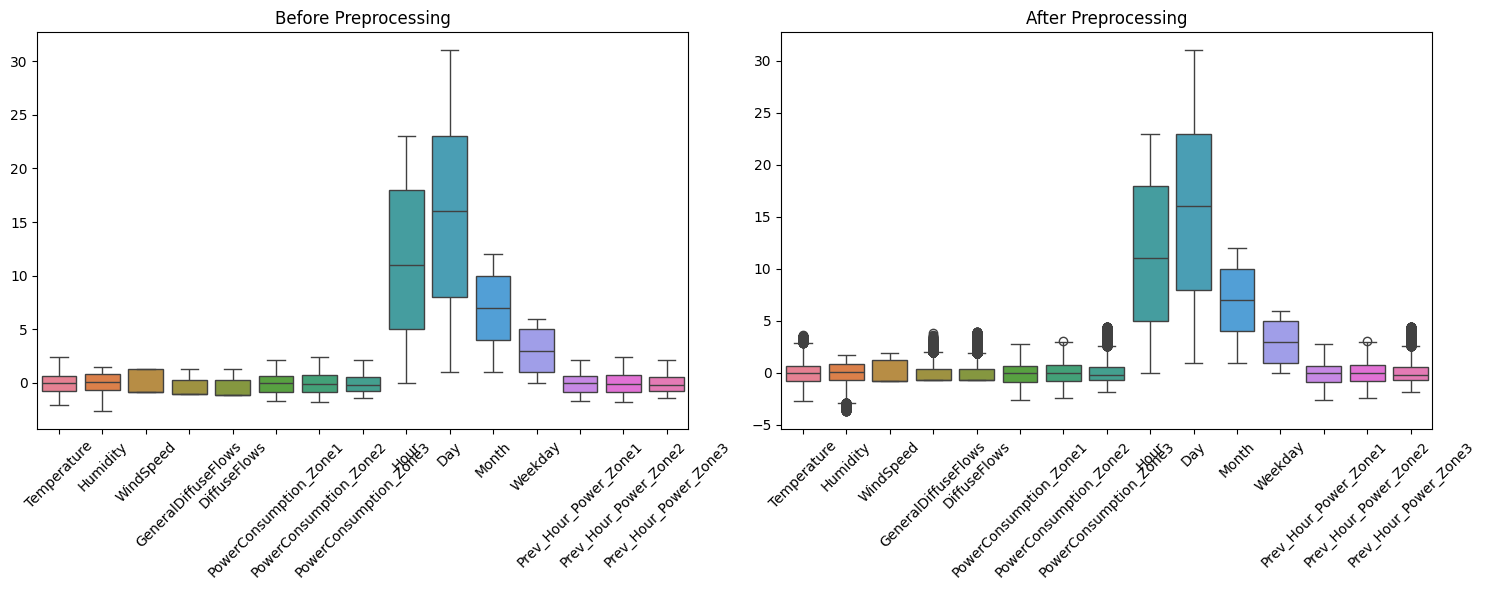

In [92]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd  # Import pandas

# Load the cleaned dataset
cleaned_dataset = pd.read_csv("cleaned_dataset.csv") # Load the saved dataset

# Create subplots for comparison
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Box plot before preprocessing
sns.boxplot(data=cleaned_dataset, ax=axes[0])
axes[0].set_title("Before Preprocessing")
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45)

# Box plot after preprocessing
sns.boxplot(data=df, ax=axes[1])
axes[1].set_title("After Preprocessing")
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45)

plt.tight_layout()
plt.show()

In [93]:
import numpy as np
from scipy import stats

def remove_outliers_modified_zscore(dataframe, column, threshold=3.5):
  median = np.median(dataframe[column])
  MAD = np.median(np.abs(dataframe[column] - median))
  modified_z_scores = 0.6745 * (dataframe[column] - median) / MAD
  return dataframe[(np.abs(modified_z_scores) < threshold)]

  numeric_columns = df.select_dtypes(include=['float64']).columns
  for col in numeric_columns:
    df = remove_outliers_modified_zscore(df, col, threshold=3.5)

<ipython-input-94-cab2344229a6>:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45)
<ipython-input-94-cab2344229a6>:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45)


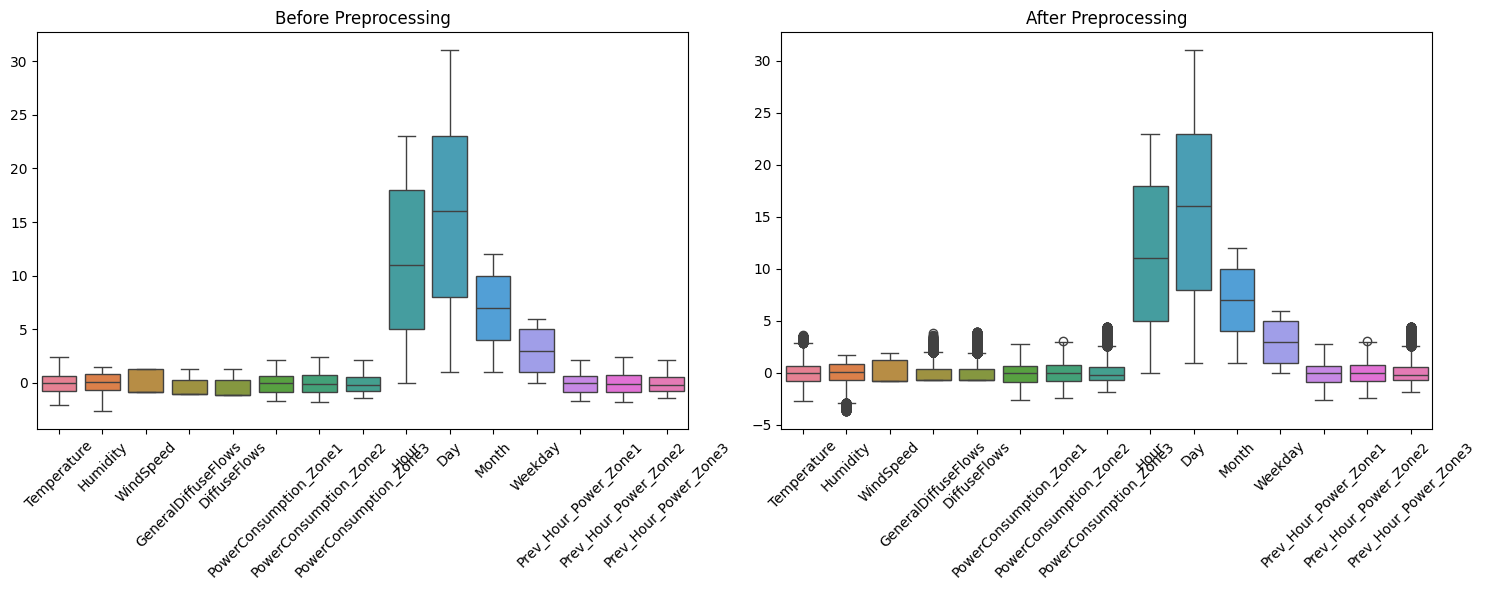

In [94]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd  # Import pandas

# Load the cleaned dataset
cleaned_dataset = pd.read_csv("cleaned_dataset.csv") # Load the saved dataset

# Create subplots for comparison
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Box plot before preprocessing
sns.boxplot(data=cleaned_dataset, ax=axes[0])
axes[0].set_title("Before Preprocessing")
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45)

# Box plot after preprocessing
sns.boxplot(data=df, ax=axes[1])
axes[1].set_title("After Preprocessing")
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45)

plt.tight_layout()
plt.show()

In [95]:
from sklearn.neighbors import LocalOutlierFactor
def remove_outliers_lof(dataframe, contamination=0.05):
  lof = LocalOutlierFactor(contamination=contamination)
  outlier_predictions = lof.fit_predict(dataframe.select_dtypes(include=['float64']))
  return dataframe[outlier_predictions != -1]  # -1 indicates outliers

  df = remove_outliers_lof(df)

<ipython-input-96-b834871ecbbf>:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45, ha='right')
<ipython-input-96-b834871ecbbf>:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, ha='right')


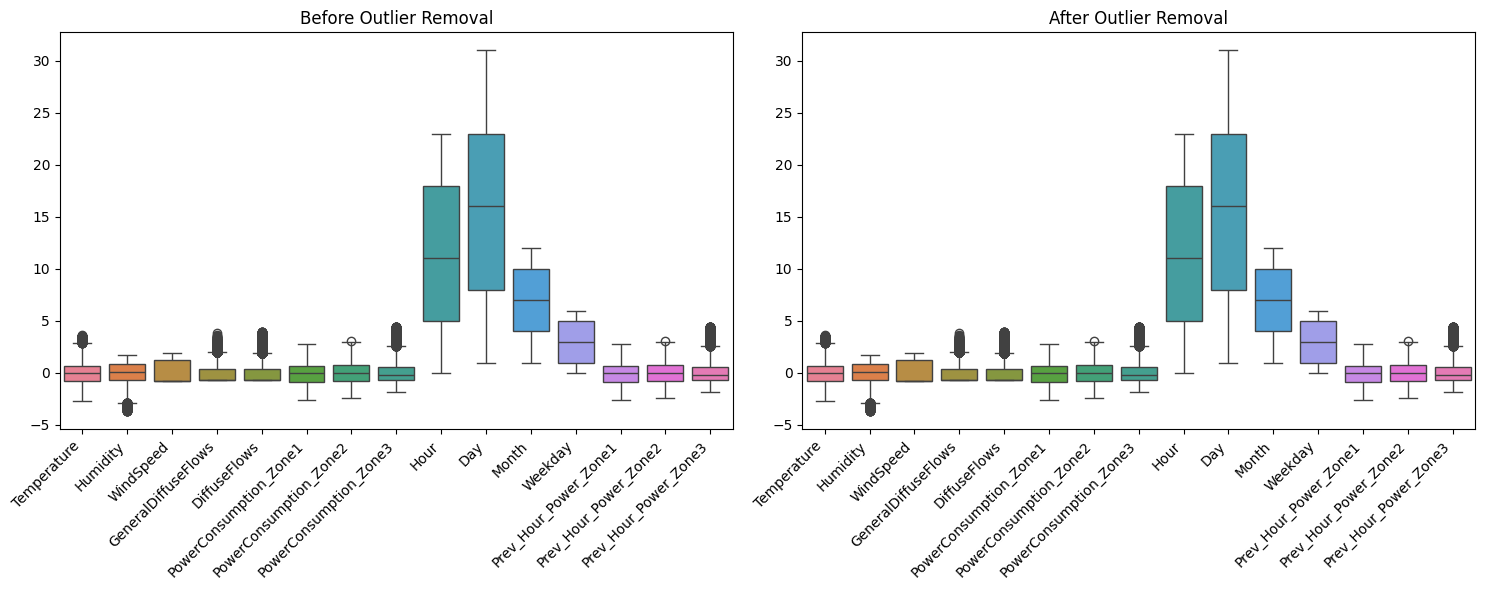

In [96]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Assuming 'df' is your DataFrame containing the data

# Create a copy of the original DataFrame for comparison
original_df = df.copy()

# ... (Apply your chosen outlier removal method here) ...

# Create subplots for comparison
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Box plot before outlier removal
sns.boxplot(data=original_df, ax=axes[0])
axes[0].set_title("Before Outlier Removal")
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45, ha='right')

# Box plot after outlier removal
sns.boxplot(data=df, ax=axes[1])
axes[1].set_title("After Outlier Removal")
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.show()

In [97]:
from scipy.stats.mstats import winsorize

for col in df.select_dtypes(include=['float64']).columns:
    df[col] = winsorize(df[col], limits=[0.01, 0.01])  # Capping only top & bottom 1%


In [98]:
print(f"Dataset size after fixing outlier removal: {df.shape}")


Dataset size after fixing outlier removal: (41781, 16)


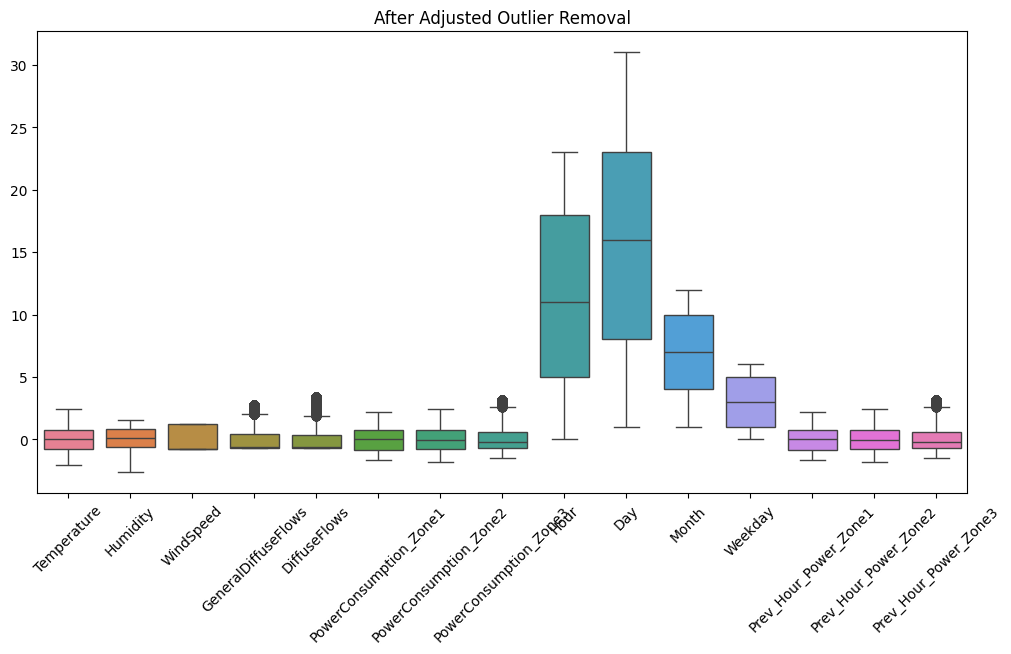

In [99]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
sns.boxplot(data=df)
plt.xticks(rotation=45)
plt.title("After Adjusted Outlier Removal")
plt.show()


In [100]:
# Identify columns with remaining outliers
remaining_outliers = []
for col in df.select_dtypes(include=['float64']).columns:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]

    if not outliers.empty:
        remaining_outliers.append(col)

print("Columns still having outliers:", remaining_outliers)


Columns still having outliers: ['GeneralDiffuseFlows', 'DiffuseFlows', 'PowerConsumption_Zone3', 'Prev_Hour_Power_Zone3']


/usr/local/lib/python3.11/dist-packages/numpy/lib/function_base.py:4824: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(
/usr/local/lib/python3.11/dist-packages/numpy/lib/function_base.py:4824: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(
/usr/local/lib/python3.11/dist-packages/numpy/lib/function_base.py:4824: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(
/usr/local/lib/python3.11/dist-packages/numpy/lib/function_base.py:4824: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(
/usr/local/lib/python3.11/dist-packages/numpy/lib/function_base.py:4824: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(
/usr/local/lib/python3.11/dist-packages/numpy/lib/function_base.py:4824: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition

In [101]:
from scipy.stats.mstats import winsorize

for col in remaining_outliers:
    df[col] = winsorize(df[col], limits=[0.02, 0.02])  # Caps top & bottom 2%


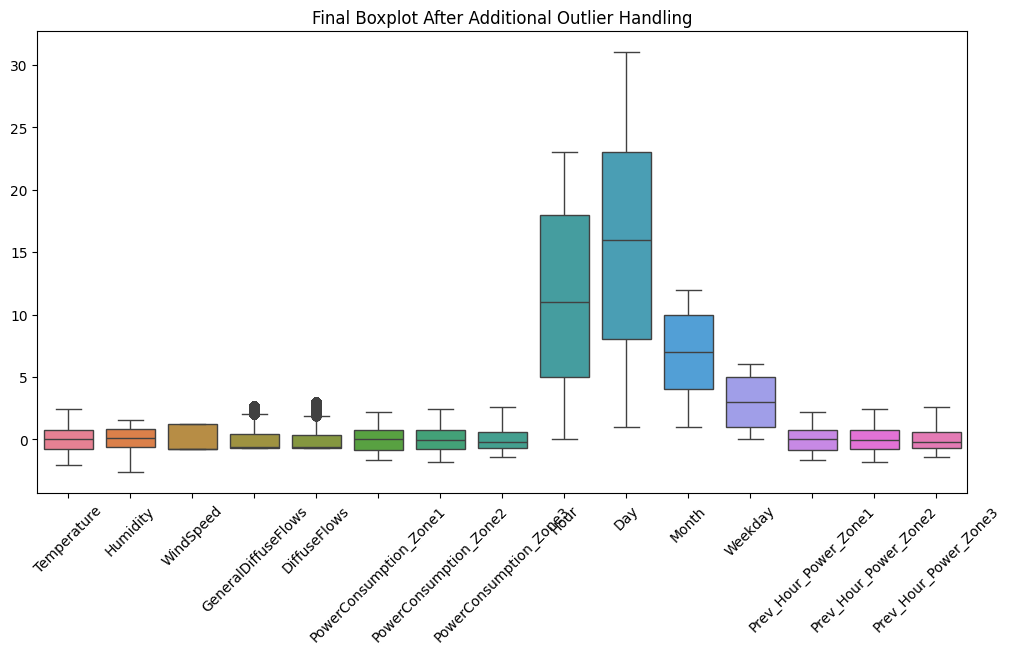

In [102]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
sns.boxplot(data=df)
plt.xticks(rotation=45)
plt.title("Final Boxplot After Additional Outlier Handling")
plt.show()


In [103]:
# Identify columns with remaining outliers
remaining_outliers = []
for col in df.select_dtypes(include=['float64']).columns:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]

    if not outliers.empty:
        remaining_outliers.append(col)

print("Columns still having outliers:", remaining_outliers)


Columns still having outliers: ['GeneralDiffuseFlows', 'DiffuseFlows']


/usr/local/lib/python3.11/dist-packages/numpy/lib/function_base.py:4824: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(
/usr/local/lib/python3.11/dist-packages/numpy/lib/function_base.py:4824: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(
/usr/local/lib/python3.11/dist-packages/numpy/lib/function_base.py:4824: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(
/usr/local/lib/python3.11/dist-packages/numpy/lib/function_base.py:4824: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(
/usr/local/lib/python3.11/dist-packages/numpy/lib/function_base.py:4824: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(
/usr/local/lib/python3.11/dist-packages/numpy/lib/function_base.py:4824: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition

In [104]:
import numpy as np

for col in remaining_outliers:
    df[col] = np.log1p(df[col])  # log(1 + x) to handle zero values


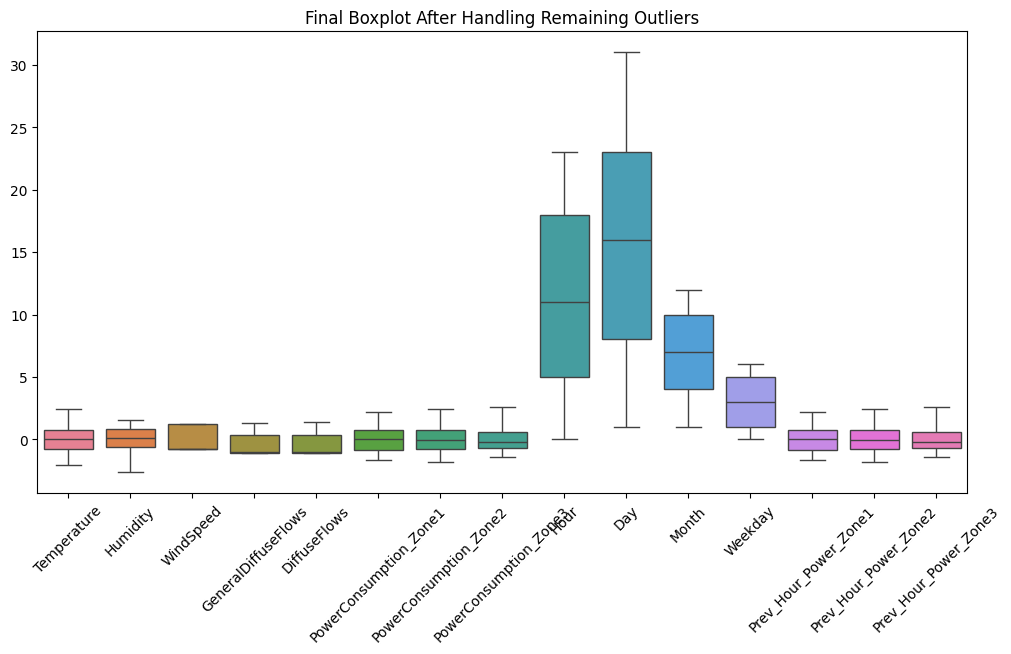

In [105]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
sns.boxplot(data=df)
plt.xticks(rotation=45)
plt.title("Final Boxplot After Handling Remaining Outliers")
plt.show()


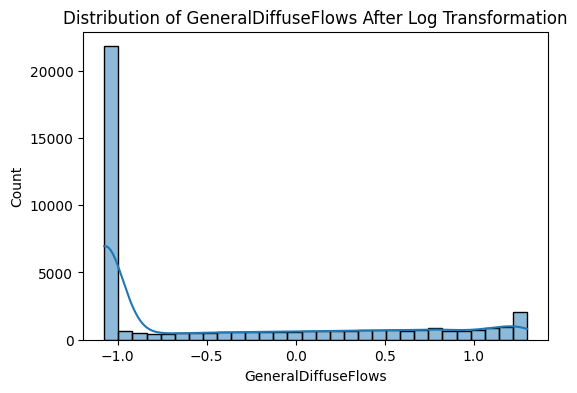

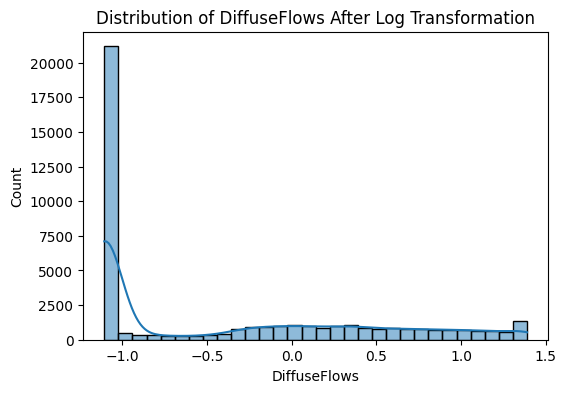

In [106]:
import seaborn as sns
import matplotlib.pyplot as plt

for col in remaining_outliers:
    plt.figure(figsize=(6,4))
    sns.histplot(df[col], kde=True, bins=30)
    plt.title(f"Distribution of {col} After Log Transformation")
    plt.show()


In [107]:
# Save the cleaned dataset
df.to_csv("cleaned_dataset.csv", index=False)
print("Preprocessed dataset saved successfully!")


Preprocessed dataset saved successfully!
